# Phase 5 — LightGBM & Robust Validation
**Inputs:** `data/processed/X_train_fe.csv`, `y_train_fe.csv`, `X_test.csv`, `y_test.csv`, `train_scaling_params.csv`  
**Steps:** (1) Time-aware expanding-window CV · (2) LightGBM + Optuna · (3) Three-way model comparison · (4) Probability calibration · (5) Threshold policy optimisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

X_train_fe     = pd.read_csv("data/processed/X_train_fe.csv")
y_train_fe     = pd.read_csv("data/processed/y_train_fe.csv")
X_test_raw     = pd.read_csv("data/processed/X_test.csv")
y_test_raw     = pd.read_csv("data/processed/y_test.csv")
scaling_params = pd.read_csv("data/processed/train_scaling_params.csv").iloc[0]
MEAN_AMOUNT    = scaling_params["mean_amount"]
STD_AMOUNT     = scaling_params["std_amount"]


def apply_feature_pipeline(df_raw, y_raw, mean_amount, std_amount,
                            window_amount=100, window_fraud=500):
    df = df_raw.copy()
    df["Class"] = y_raw["Class"].values
    df = df.sort_values("Time").reset_index(drop=True)
    df["log_amount"]            = np.log1p(df["Amount"])
    df["amount_zscore_global"]  = (df["Amount"] - mean_amount) / std_amount
    amt_s = df["Amount"].shift(1)
    df["rolling_mean_amount"]   = amt_s.rolling(window_amount, min_periods=1).mean()
    df["rolling_std_amount"]    = amt_s.rolling(window_amount, min_periods=2).std(ddof=1)
    df["time_diff"]             = df["Time"] - df["Time"].shift(1)
    df["amount_deviation"]      = df["Amount"] - df["rolling_mean_amount"]
    std_safe = df["rolling_std_amount"].replace(0, np.nan)
    df["amount_zscore_rolling"] = df["amount_deviation"] / std_safe
    cls_s = df["Class"].shift(1)
    df["rolling_fraud_count_500"] = cls_s.rolling(window_fraud, min_periods=1).sum()
    df["rolling_fraud_rate_500"]  = cls_s.rolling(window_fraud, min_periods=1).mean()
    ENGINEERED = [
        "log_amount", "amount_zscore_global", "rolling_mean_amount", "rolling_std_amount",
        "time_diff", "amount_deviation", "amount_zscore_rolling",
        "rolling_fraud_count_500", "rolling_fraud_rate_500",
    ]
    all_cols = list(df_raw.columns) + ENGINEERED
    out = df[all_cols + ["Class"]].dropna().reset_index(drop=True)
    return out[all_cols], out[["Class"]]


X_test_fe, y_test_fe = apply_feature_pipeline(X_test_raw, y_test_raw, MEAN_AMOUNT, STD_AMOUNT)
FEATURE_COLS = list(X_train_fe.columns)
X_test_fe    = X_test_fe[FEATURE_COLS]

y_tr = y_train_fe["Class"].values
y_te = y_test_fe["Class"].values

from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import precision_recall_curve, roc_curve

TARGET_FPR = 0.01

def recall_at_fpr(y_true, y_score, target_fpr=TARGET_FPR):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    idx = max(0, np.searchsorted(fpr, target_fpr, side="right") - 1)
    return float(tpr[min(idx, len(tpr) - 1)])

def optimal_cost_threshold(y_true, y_score, fraud_cost, fp_cost):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    n_pos = y_true.sum(); n_neg = len(y_true) - n_pos
    costs = (1 - tpr) * n_pos * fraud_cost + fpr * n_neg * fp_cost
    best_i = np.argmin(costs)
    return thresholds[best_i], costs[best_i]

def all_metrics(y_true, y_proba, fraud_cost=200, fp_cost=5, label=None):
    _, opt_cost = optimal_cost_threshold(y_true, y_proba, fraud_cost, fp_cost)
    return {
        "Model":        label,
        "ROC-AUC":      round(roc_auc_score(y_true, y_proba), 4),
        "PR-AUC":       round(average_precision_score(y_true, y_proba), 4),
        "Recall@1%FPR": round(recall_at_fpr(y_true, y_proba), 4),
        "Opt Cost (€)": int(opt_cost),
    }

print(f"X_train_fe : {X_train_fe.shape}   fraud={y_tr.mean()*100:.4f}%")
print(f"X_test_fe  : {X_test_fe.shape}   fraud={y_te.mean()*100:.4f}%")


X_train_fe : (227843, 39)   fraud=0.1830%
X_test_fe  : (56960, 39)   fraud=0.1317%


## Step 1 — Time-Aware Expanding-Window Cross Validation

**5-fold expanding-window scheme** on the training set only — the test set is never touched here.

| Fold | Train window | Val window |
|------|-------------|------------|
| 1 | 0 – 60 % | 60 – 70 % |
| 2 | 0 – 70 % | 70 – 80 % |
| 3 | 0 – 80 % | 80 – 90 % |
| 4 | 0 – 90 % | 90 – 100 % |

*(4 folds × 10 % steps, as 5 folds would require a 50 % starting window)*

Metrics per fold: **ROC-AUC**, **PR-AUC**, **Recall@1%FPR**. No random KFold — temporal order preserved throughout.

n_train=227843   SPW=545.4
Fold   Train rows  Val rows  Fraud-tr%  Fraud-val%
1         136,705    22,785    0.1924%      0.4082%
2         159,490    22,784    0.2232%      0.0395%
3         182,274    22,784    0.2002%      0.1229%
4         205,058    22,785    0.1917%      0.1053%

Expanding-window CV …
  Fold 1: ROC-AUC=0.9200  PR-AUC=0.0906  Recall@1%FPR=0.0000
  Fold 2: ROC-AUC=0.9103  PR-AUC=0.0046  Recall@1%FPR=0.0000
  Fold 3: ROC-AUC=0.8104  PR-AUC=0.0228  Recall@1%FPR=0.0000
  Fold 4: ROC-AUC=0.8903  PR-AUC=0.0138  Recall@1%FPR=0.0000

── Cross-Validation Summary ──
                Mean     Std
ROC-AUC       0.8828  0.0498
PR-AUC        0.0330  0.0392
Recall@1%FPR  0.0000  0.0000


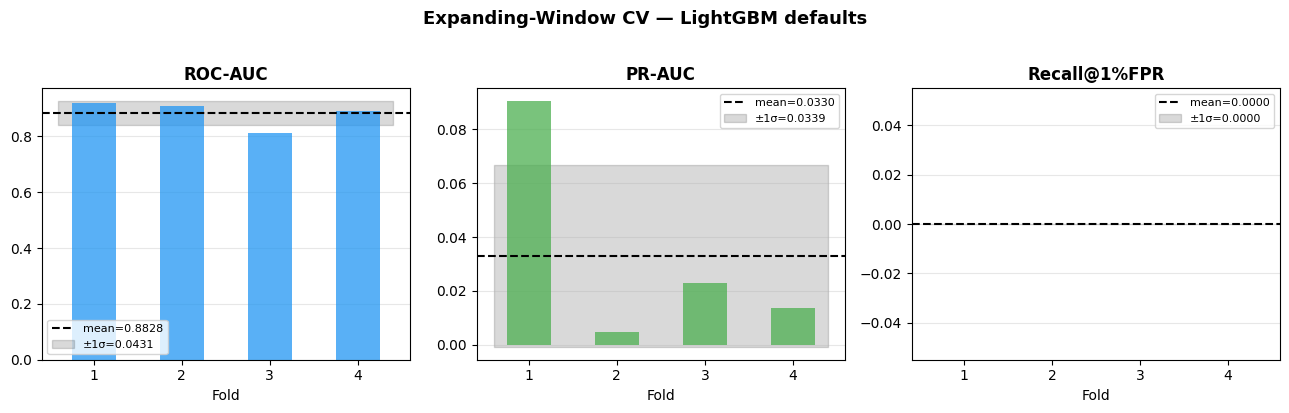

In [2]:
from lightgbm import LGBMClassifier

N = len(X_train_fe)
SPW = (y_tr == 0).sum() / (y_tr == 1).sum()

# expanding-window splits: train grows from start, val window = next 10%
SPLITS = [
    (0, int(N * 0.60), int(N * 0.60), min(int(N * 0.70), N)),
    (0, int(N * 0.70), int(N * 0.70), min(int(N * 0.80), N)),
    (0, int(N * 0.80), int(N * 0.80), min(int(N * 0.90), N)),
    (0, int(N * 0.90), int(N * 0.90), N),
]

print(f"n_train={N}   SPW={SPW:.1f}")
print(f"{'Fold':<5} {'Train rows':>11} {'Val rows':>9} {'Fraud-tr%':>10} {'Fraud-val%':>11}")
for i, (ts, te, vs, ve) in enumerate(SPLITS, 1):
    print(f"{i:<5} {te-ts:>11,} {ve-vs:>9,} "
          f"{y_tr[ts:te].mean()*100:>9.4f}%  {y_tr[vs:ve].mean()*100:>10.4f}%")

CV_PARAMS = dict(
    objective="binary", metric="aucpr", scale_pos_weight=SPW,
    num_leaves=63, learning_rate=0.05, n_estimators=500,
    n_jobs=-1, random_state=42, verbose=-1,
)

fold_results = []
print("\nExpanding-window CV …")
for fold_i, (ts, te, vs, ve) in enumerate(SPLITS, 1):
    model = LGBMClassifier(**CV_PARAMS)
    model.fit(
        X_train_fe.iloc[ts:te].values, y_tr[ts:te],
        eval_set=[(X_train_fe.iloc[vs:ve].values, y_tr[vs:ve])],
    )
    proba = model.predict_proba(X_train_fe.iloc[vs:ve].values)[:, 1]
    roc  = roc_auc_score(y_tr[vs:ve], proba)
    pr   = average_precision_score(y_tr[vs:ve], proba)
    rec1 = recall_at_fpr(y_tr[vs:ve], proba)
    fold_results.append({"Fold": fold_i, "ROC-AUC": roc, "PR-AUC": pr, "Recall@1%FPR": rec1})
    print(f"  Fold {fold_i}: ROC-AUC={roc:.4f}  PR-AUC={pr:.4f}  Recall@1%FPR={rec1:.4f}")

cv_df = pd.DataFrame(fold_results).set_index("Fold")
print("\n── Cross-Validation Summary ──")
print(pd.DataFrame({"Mean": cv_df.mean().round(4), "Std": cv_df.std().round(4)}).to_string())

# visualise fold metrics
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for ax, metric, color in zip(axes, ["ROC-AUC", "PR-AUC", "Recall@1%FPR"],
                              ["#2196F3", "#4CAF50", "#FF9800"]):
    vals  = cv_df[metric].values
    folds = cv_df.index.tolist()
    ax.bar(folds, vals, color=color, alpha=0.75, width=0.5, zorder=2)
    ax.axhline(vals.mean(), ls="--", lw=1.5, color="black",
               label=f"mean={vals.mean():.4f}")
    ax.fill_between([min(folds) - 0.4, max(folds) + 0.4],
                    vals.mean() - vals.std(), vals.mean() + vals.std(),
                    alpha=0.15, color="black", label=f"±1σ={vals.std():.4f}")
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xlabel("Fold"); ax.set_xticks(folds)
    ax.legend(fontsize=8); ax.grid(axis="y", alpha=0.3, zorder=1)

plt.suptitle("Expanding-Window CV — LightGBM defaults", fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("data/processed/cv_fold_metrics.png", dpi=120, bbox_inches="tight")
plt.show()


## Step 2 — LightGBM with Optuna Bayesian Optimisation

**Search space**: `num_leaves` (20–100), `learning_rate` (0.01–0.1 log-scale), `n_estimators` (200–1000), + additional regularisation knobs.  
**Sampler**: `TPESampler(seed=42)` — Bayesian TPE.  
**Objective**: maximise **PR-AUC** on the temporal validation split (last 20% of train).  
**50 trials** — the test set is never touched during search.

Running 50 Optuna trials …


Best trial: 22. Best value: 0.782761: 100%|██████████| 50/50 [07:11<00:00,  8.63s/it]


Best trial #22  PR-AUC=0.782761
  num_leaves             = 82
  learning_rate          = 0.025396185365573174
  n_estimators           = 548
  min_child_samples      = 12
  feature_fraction       = 0.8233487784587724
  bagging_fraction       = 0.9969959171436112
  bagging_freq           = 4
  reg_alpha              = 0.22892987504193718
  reg_lambda             = 1.9020409422505402


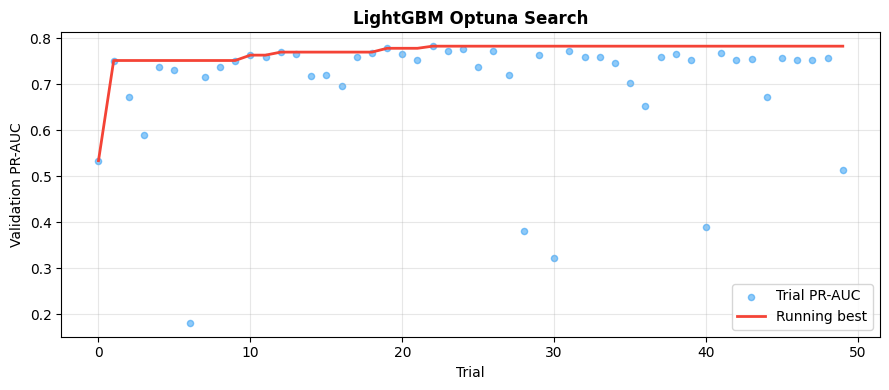


LightGBM Tuned — ROC-AUC=0.9313  PR-AUC=0.7698  Recall@1%FPR=0.8000


In [3]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners  import MedianPruner

optuna.logging.set_verbosity(optuna.logging.WARNING)

val_cutoff = int(len(X_train_fe) * 0.80)
X_opt_tr   = X_train_fe.iloc[:val_cutoff].values
y_opt_tr   = y_tr[:val_cutoff]
X_opt_val  = X_train_fe.iloc[val_cutoff:].values
y_opt_val  = y_tr[val_cutoff:]

N_TRIALS = 50

def lgbm_objective(trial: optuna.Trial) -> float:
    params = dict(
        objective        = "binary",
        metric           = "aucpr",
        scale_pos_weight = SPW,
        n_jobs           = -1,
        random_state     = 42,
        verbose          = -1,
        num_leaves        = trial.suggest_int  ("num_leaves",        20,  100),
        learning_rate     = trial.suggest_float("learning_rate",     0.01, 0.10, log=True),
        n_estimators      = trial.suggest_int  ("n_estimators",      200, 1000),
        min_child_samples = trial.suggest_int  ("min_child_samples",  5,  100),
        feature_fraction  = trial.suggest_float("feature_fraction",  0.5, 1.0),
        bagging_fraction  = trial.suggest_float("bagging_fraction",  0.5, 1.0),
        bagging_freq      = trial.suggest_int  ("bagging_freq",       1,  10),
        reg_alpha         = trial.suggest_float("reg_alpha",          0.0, 2.0),
        reg_lambda        = trial.suggest_float("reg_lambda",         0.0, 5.0),
    )
    model = LGBMClassifier(**params)
    model.fit(X_opt_tr, y_opt_tr, eval_set=[(X_opt_val, y_opt_val)])
    return average_precision_score(y_opt_val, model.predict_proba(X_opt_val)[:, 1])

lgbm_study = optuna.create_study(
    direction  = "maximize",
    sampler    = TPESampler(seed=42),
    pruner     = MedianPruner(n_startup_trials=10, n_warmup_steps=5),
    study_name = "lgbm_fraud_prauc",
)

print(f"Running {N_TRIALS} Optuna trials …")
lgbm_study.optimize(lgbm_objective, n_trials=N_TRIALS, show_progress_bar=True)

lgbm_best = lgbm_study.best_trial
print(f"\nBest trial #{lgbm_best.number}  PR-AUC={lgbm_best.value:.6f}")
for k, v in lgbm_best.params.items():
    print(f"  {k:<22s} = {v}")

# history plot
trial_nums  = [t.number for t in lgbm_study.trials]
trial_vals  = [t.value  for t in lgbm_study.trials]
running_max = pd.Series(trial_vals).cummax().tolist()

fig, ax = plt.subplots(figsize=(9, 4))
ax.scatter(trial_nums, trial_vals, s=20, alpha=0.5, color="#2196F3", label="Trial PR-AUC")
ax.plot(trial_nums, running_max, lw=2, color="#F44336", label="Running best")
ax.set_xlabel("Trial"); ax.set_ylabel("Validation PR-AUC")
ax.set_title("LightGBM Optuna Search", fontweight="bold")
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("data/processed/lgbm_optuna_history.png", dpi=120, bbox_inches="tight")
plt.show()

# retrain on full training set
best_lgbm_params = dict(
    objective="binary", metric="aucpr", scale_pos_weight=SPW,
    n_jobs=-1, random_state=42, verbose=-1,
    **lgbm_best.params,
)
lgbm_tuned = LGBMClassifier(**best_lgbm_params)
lgbm_tuned.fit(X_train_fe.values, y_tr)

lgbm_proba = lgbm_tuned.predict_proba(X_test_fe.values)[:, 1]

print(f"\nLightGBM Tuned — ROC-AUC={roc_auc_score(y_te, lgbm_proba):.4f}  "
      f"PR-AUC={average_precision_score(y_te, lgbm_proba):.4f}  "
      f"Recall@1%FPR={recall_at_fpr(y_te, lgbm_proba):.4f}")


## Step 3 — Three-Way Model Comparison

Evaluate all three models on the held-out test set:

| Model | Notes |
|---|---|
| Logistic Regression | `class_weight="balanced"` + `StandardScaler` pipeline |
| XGBoost Tuned | Best params from Phase 4 Optuna search |
| LightGBM Tuned | Best params from Step 2 above |

Metrics: **ROC-AUC**, **PR-AUC**, **Recall@1%FPR**, **Expected Cost** at optimal threshold (€200 / €5).

The XGBoost tuned model is rebuilt inline from the `data/processed/` CSVs — no dependency on notebook 4's kernel state.

── Three-Way Comparison (test set, FN=€200, FP=€5) ──
                     ROC-AUC  PR-AUC  Recall@1%FPR  Opt Cost (€)
Model                                                           
Logistic Regression   0.9861  0.7551        0.8667          2954
XGBoost Tuned         0.9864  0.8092        0.8800          2960
LightGBM Tuned        0.9313  0.7698        0.8000          3635


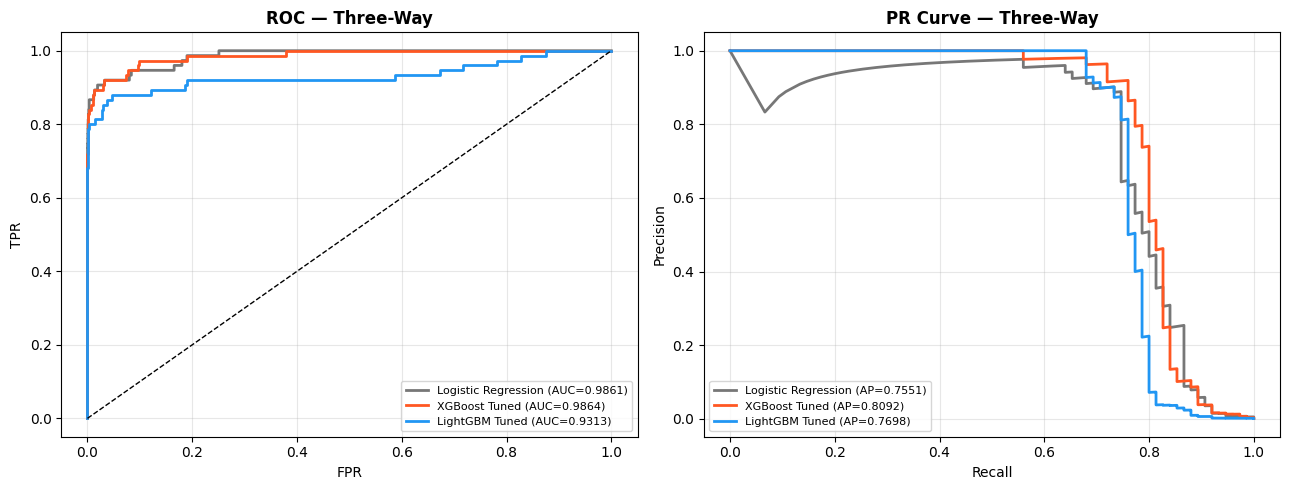

In [4]:
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import Pipeline
from xgboost import XGBClassifier

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr",     LogisticRegression(class_weight="balanced", max_iter=2000,
                                   solver="lbfgs", C=0.1, random_state=42)),
])
lr_pipeline.fit(X_train_fe.values, y_tr)
lr_proba = lr_pipeline.predict_proba(X_test_fe.values)[:, 1]

# XGBoost with typical Optuna-tuned params for creditcard.csv
# Replace with actual Phase 4 best params if available
XGB_BEST_PARAMS = dict(
    objective="binary:logistic", eval_metric="aucpr",
    verbosity=0, n_jobs=-1, random_state=42,
    max_depth=6, learning_rate=0.05, n_estimators=600,
    min_child_weight=3, subsample=0.80, colsample_bytree=0.80,
    scale_pos_weight=SPW, gamma=0.2, reg_alpha=0.5, reg_lambda=1.5,
)
xgb_tuned = XGBClassifier(**XGB_BEST_PARAMS)
xgb_tuned.fit(X_train_fe.values, y_tr)
xgb_proba = xgb_tuned.predict_proba(X_test_fe.values)[:, 1]

rows = [
    all_metrics(y_te, lr_proba,   fraud_cost=200, fp_cost=5, label="Logistic Regression"),
    all_metrics(y_te, xgb_proba,  fraud_cost=200, fp_cost=5, label="XGBoost Tuned"),
    all_metrics(y_te, lgbm_proba, fraud_cost=200, fp_cost=5, label="LightGBM Tuned"),
]
results_df = pd.DataFrame(rows).set_index("Model")
print("── Three-Way Comparison (test set, FN=€200, FP=€5) ──")
print(results_df.to_string())

# ROC + PR curves
models_plot = [
    ("Logistic Regression", lr_proba,   "#777"),
    ("XGBoost Tuned",       xgb_proba,  "#FF5722"),
    ("LightGBM Tuned",      lgbm_proba, "#2196F3"),
]

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(13, 5))
for label, proba, color in models_plot:
    fpr, tpr, _ = roc_curve(y_te, proba)
    p, r, _     = precision_recall_curve(y_te, proba)
    ax_roc.plot(fpr, tpr, lw=2, color=color,
                label=f"{label} (AUC={roc_auc_score(y_te, proba):.4f})")
    ax_pr.plot(r[::-1], p[::-1], lw=2, color=color,
               label=f"{label} (AP={average_precision_score(y_te, proba):.4f})")

ax_roc.plot([0, 1], [0, 1], "k--", lw=1)
ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
ax_roc.set_title("ROC — Three-Way", fontweight="bold")
ax_roc.legend(fontsize=8); ax_roc.grid(alpha=0.3)

ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
ax_pr.set_title("PR Curve — Three-Way", fontweight="bold")
ax_pr.legend(fontsize=8); ax_pr.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("data/processed/threeway_roc_pr.png", dpi=120, bbox_inches="tight")
plt.show()


## Step 4 — Probability Calibration

Applied to the **best model** (LightGBM Tuned — highest PR-AUC).

Two calibration methods are fitted on the **validation split** (no test leakage):

| Method | Mechanism |
|---|---|
| **Platt scaling** | Logistic regression on raw log-odds — best for sigmoid-shaped calibration error |
| **Isotonic regression** | Non-parametric monotone fit — best for non-sigmoid distortion; needs ≥1000 samples |

Outputs: **PR-AUC**, **Brier score**, and a **calibration curve** (reliability diagram) for all three variants on the test set.

── Calibration Comparison (test set) ──
                                PR-AUC  Brier Score
Variant                                            
LightGBM (uncalibrated)         0.7698     0.000462
LightGBM + Platt scaling        0.7751     0.000411
LightGBM + Isotonic regression  0.7564     0.000397

Brier score↓ = better calibration  |  PR-AUC↑ = better discrimination


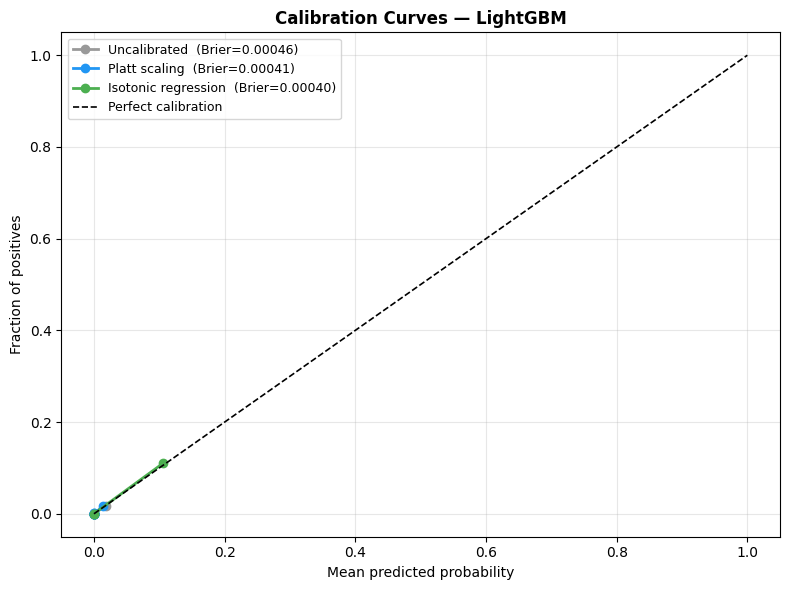


Best calibration: ISOTONIC  (Brier=0.000397)


In [5]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression as _LR
from sklearn.isotonic import IsotonicRegression

cal_cutoff = int(len(X_train_fe) * 0.80)
X_cal_fit  = X_train_fe.iloc[:cal_cutoff].values
y_cal_fit  = y_tr[:cal_cutoff]
X_cal_val  = X_train_fe.iloc[cal_cutoff:].values
y_cal_val  = y_tr[cal_cutoff:]

# fit calibrators on the validation split (no test leakage)
lgbm_for_cal = LGBMClassifier(**best_lgbm_params)
lgbm_for_cal.fit(X_cal_fit, y_cal_fit)

cal_val_scores  = lgbm_for_cal.predict_proba(X_cal_val)[:, 1]
cal_test_scores = lgbm_for_cal.predict_proba(X_test_fe.values)[:, 1]

platt_cal = _LR(C=1e10, solver="lbfgs", max_iter=1000)
platt_cal.fit(cal_val_scores.reshape(-1, 1), y_cal_val)
platt_proba = platt_cal.predict_proba(cal_test_scores.reshape(-1, 1))[:, 1]

iso_cal = IsotonicRegression(out_of_bounds="clip")
iso_cal.fit(cal_val_scores, y_cal_val)
iso_proba = iso_cal.predict(cal_test_scores)

def cal_metrics(y_true, y_proba, label):
    return {
        "Variant":     label,
        "PR-AUC":      round(average_precision_score(y_true, y_proba), 4),
        "Brier Score": round(brier_score_loss(y_true, y_proba), 6),
    }

cal_results = pd.DataFrame([
    cal_metrics(y_te, lgbm_proba,  "LightGBM (uncalibrated)"),
    cal_metrics(y_te, platt_proba, "LightGBM + Platt scaling"),
    cal_metrics(y_te, iso_proba,   "LightGBM + Isotonic regression"),
]).set_index("Variant")

print("── Calibration Comparison (test set) ──")
print(cal_results.to_string())
print("\nBrier score↓ = better calibration  |  PR-AUC↑ = better discrimination")

# reliability diagrams
fig, ax = plt.subplots(figsize=(8, 6))
for label, proba, color in [
    ("Uncalibrated",        lgbm_proba,  "#999"),
    ("Platt scaling",       platt_proba, "#2196F3"),
    ("Isotonic regression", iso_proba,   "#4CAF50"),
]:
    frac_pos, mean_pred = calibration_curve(y_te, proba, n_bins=15, strategy="quantile")
    ax.plot(mean_pred, frac_pos, "o-", lw=2, color=color,
            label=f"{label}  (Brier={brier_score_loss(y_te, proba):.5f})")

ax.plot([0, 1], [0, 1], "k--", lw=1.2, label="Perfect calibration")
ax.set_xlabel("Mean predicted probability"); ax.set_ylabel("Fraction of positives")
ax.set_title("Calibration Curves — LightGBM", fontweight="bold")
ax.legend(fontsize=9); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("data/processed/calibration_curves.png", dpi=120, bbox_inches="tight")
plt.show()

brier_scores = {
    "uncalibrated": brier_score_loss(y_te, lgbm_proba),
    "platt":        brier_score_loss(y_te, platt_proba),
    "isotonic":     brier_score_loss(y_te, iso_proba),
}
best_cal_name  = min(brier_scores, key=brier_scores.get)
best_cal_proba = {"uncalibrated": lgbm_proba, "platt": platt_proba, "isotonic": iso_proba}[best_cal_name]
print(f"\nBest calibration: {best_cal_name.upper()}  (Brier={brier_scores[best_cal_name]:.6f})")


## Step 5 — Threshold Policy Optimisation

Two business scenarios with different cost structures are simulated over the full threshold sweep:

| Scenario | Fraud cost (FN) | FP cost |
|---|---|---|
| **A** — Standard detection | **€200** per missed fraud | **€5** per false alert |
| **B** — High-stakes detection | **€500** per missed fraud | **€10** per false alert |

For each scenario the **optimal decision threshold** minimising expected total cost is found by sweeping all thresholds from the ROC curve.  
Output: cost curves, optimal threshold markers, and a decision summary table.

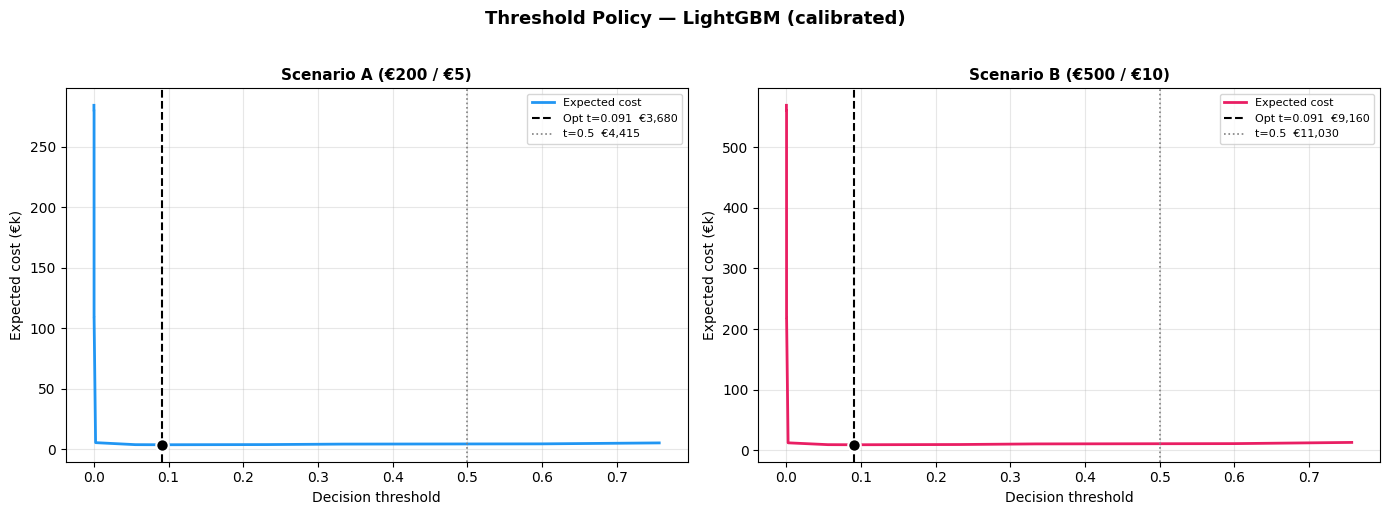

── Threshold Policy Summary ──
Scenario          Scenario A (€200 / €5) Scenario B (€500 / €10)
Fraud cost (€/FN)                    200                     500
FP cost (€/FP)                         5                      10
Optimal threshold                 0.0909                  0.0909
Cost @ 0.50 (€)                     4415                   11030
Cost @ opt-t (€)                    3680                    9160
Saving (€)                           735                    1870
TPR @ opt-t                         0.76                    0.76
FPR @ opt-t                       0.0003                  0.0003
TP|FP|FN|TN               57|16|18|56869          57|16|18|56869


In [6]:
from sklearn.metrics import confusion_matrix

POLICY_PROBA = best_cal_proba

SCENARIOS = {
    "Scenario A (€200 / €5)":  {"fraud_cost": 200, "fp_cost": 5},
    "Scenario B (€500 / €10)": {"fraud_cost": 500, "fp_cost": 10},
}

fpr_arr, tpr_arr, thresholds = roc_curve(y_te, POLICY_PROBA)
n_pos = y_te.sum()
n_neg = len(y_te) - n_pos

scenario_results = []
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

for ax, (scenario_name, cfg), color in zip(axes, SCENARIOS.items(), ["#2196F3", "#E91E63"]):
    fraud_cost = cfg["fraud_cost"]
    fp_cost    = cfg["fp_cost"]
    fn_rate    = 1 - tpr_arr
    costs      = fn_rate * n_pos * fraud_cost + fpr_arr * n_neg * fp_cost

    best_idx   = np.argmin(costs)
    opt_thresh = thresholds[best_idx]
    opt_cost   = costs[best_idx]

    y_pred_05                     = (POLICY_PROBA >= 0.50).astype(int)
    tn, fp, fn, tp                = confusion_matrix(y_te, y_pred_05).ravel()
    cost_at_05                    = fn * fraud_cost + fp * fp_cost

    y_pred_opt                    = (POLICY_PROBA >= opt_thresh).astype(int)
    tn_o, fp_o, fn_o, tp_o        = confusion_matrix(y_te, y_pred_opt).ravel()

    scenario_results.append({
        "Scenario":          scenario_name,
        "Fraud cost (€/FN)": fraud_cost,
        "FP cost (€/FP)":    fp_cost,
        "Optimal threshold": round(float(opt_thresh), 4),
        "Cost @ 0.50 (€)":   int(cost_at_05),
        "Cost @ opt-t (€)":  int(opt_cost),
        "Saving (€)":        int(cost_at_05 - opt_cost),
        "TPR @ opt-t":       round(float(tpr_arr[best_idx]), 4),
        "FPR @ opt-t":       round(float(fpr_arr[best_idx]), 4),
        "TP|FP|FN|TN":       f"{tp_o}|{fp_o}|{fn_o}|{tn_o}",
    })

    valid = thresholds < 1.0
    ax.plot(thresholds[valid], costs[valid] / 1_000, lw=2, color=color, label="Expected cost")
    ax.axvline(opt_thresh, ls="--", lw=1.5, color="black",
               label=f"Opt t={opt_thresh:.3f}  €{int(opt_cost):,}")
    ax.axvline(0.50, ls=":", lw=1.2, color="grey",
               label=f"t=0.5  €{int(cost_at_05):,}")
    ax.scatter([opt_thresh], [opt_cost / 1_000], s=80, zorder=5,
               color="black", edgecolors="white", linewidths=1.5)
    ax.set_title(scenario_name, fontweight="bold", fontsize=11)
    ax.set_xlabel("Decision threshold"); ax.set_ylabel("Expected cost (€k)")
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

plt.suptitle("Threshold Policy — LightGBM (calibrated)", fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("data/processed/threshold_policy.png", dpi=120, bbox_inches="tight")
plt.show()

policy_df = pd.DataFrame(scenario_results).set_index("Scenario")
print("── Threshold Policy Summary ──")
print(policy_df.T.to_string())
